In [5]:
import numpy as np
import matplotlib.pyplot as plt

This code reproduces the 2D temporal developing jet (TDJ) problem from the paper: https://www.nature.com/articles/s43588-021-00181-1

The projection approach is explained in this paper: https://doi.org/10.1016/j.cpc.2016.02.023
(They use derivatives in the Fourier space whereas here we use 8th order finite difference)

### Initial conditions for a 2D developing jet

In [6]:
def J(X, Y, u_0, y_min=0.4, y_max=0.6, h = 0.005):
    return u_0/2*(np.tanh((Y-y_min)/h)-np.tanh((Y-y_max)/h)-1), np.zeros_like(Y)

In [7]:
def d_1(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return 2*L_box/h**2*((Y-y_max)*np.exp(-(Y-y_max)**2/h**2)+(Y-y_min)*np.exp(-(Y-y_min)**2/h**2))*(np.sin(8*np.pi*X/L_box)+np.sin(24*np.pi*X/L_box)+np.sin(6*np.pi*X/L_box))
def d_2(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return np.pi*(np.exp(-(Y-y_max)**2/h**2)+np.exp(-(Y-y_min)**2/h**2))*(8*np.cos(8*np.pi*X/L_box)+24*np.cos(24*np.pi*X/L_box)+6*np.cos(6*np.pi*X/L_box))

In [8]:
def D(X, Y, u_0, y_min, y_max, h, L_box):
    d1 = d_1(X, Y, y_min, y_max, h, L_box)
    d2 = d_2(X, Y, y_min, y_max, h, L_box)
    delta = u_0/(40*np.max(np.sqrt(d1**2+d2**2)))
    return delta*d1, delta*d2

### Define differentiation methods

In [9]:
def central_difference_1_2_x(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)
    return diff

def central_difference_1_2_y(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dx)
    return diff

def central_difference_1_8_x(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) - np.roll(f, i+1, axis=1)) 
    return diff

def central_difference_1_8_y(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) - np.roll(f, i+1, axis=0)) 
    return diff

def central_difference_2_8_x(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -205/72*f/dx**2
    return diff

def central_difference_2_2_x(f, dx):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        print(coeff)
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_8_y(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=0)) 
    diff += -205/72*f/dx**2
    return diff

def laplace(f, dx):
    diff = np.zeros_like(f)
    diff = central_difference_2_8_x(f, dx) + central_difference_2_8_y(f, dx)
    return diff

def Dx(f, dx):
    return central_difference_1_8_x(f, dx)

def Dy(f, dx):
    return central_difference_1_8_y(f, dx)

def Dx2(f, dx):
    return central_difference_2_8_x(f, dx)

def Dy2(f, dx):
    return central_difference_2_8_y(f, dx)

### Convection and diffusion 

In [10]:
def convection(u, v, dt, dx):
    dudx = Dx(u, dx)
    dudy = Dy(u, dx)
    dvdx = Dx(v, dx)
    dvdy = Dy(v, dx)

    duudx = Dx(u*u, dx)
    duudy = Dy(u*u, dx)
    duvdx = Dx(u*v, dx)
    duvdy = Dy(u*v, dx)
    dvvdx = Dx(v*v, dx)
    dvvdy = Dy(v*v, dx)

    du = -dt/2 * (u*dudx + v*dudy + duudx + duvdy)
    dv = -dt/2 * (u*dvdx + v*dvdy + duvdx + dvvdy)

    return du, dv

In [11]:
def diffusion(u, v, Re, dt, dx):
    du = dt/Re * (Dx2(u, dx) + Dy2(u, dx))
    dv = dt/Re * (Dx2(v, dx) + Dy2(v, dx))

    return du, dv

### Projeciton step in Fourier space

In [12]:
def project(du, dv, Kx, Ky):
    # fft
    FU = np.fft.fft2(du)
    FV = np.fft.fft2(dv)

    # projection so that the wave vector (kx,ky) is orthogonal to (fu,fv)
    FUU = FU - (Kx*FU + Ky*FV)*Kx/np.maximum(1e-14, (Kx**2 + Ky**2))
    FVV = FV - (Kx*FU + Ky*FV)*Ky/np.maximum(1e-14, (Kx**2 + Ky**2))

    # ifft
    du = np.real(np.fft.ifft2(FUU))
    dv = np.real(np.fft.ifft2(FVV))

    return du, dv

### Solve Navier Stokes equations for one time step

In [13]:
def solveNS(u, v, Kx, Ky, Re, dt, dx):
    u_old = u
    u_temp = u
    v_old = v 
    v_temp = v

    # Euler
    a = [1, 0, 0, 0]
    b = [0, 0, 0, 0]

    # RK2
    # a = [0, 1, 0, 0]
    # b = [1/2, 0, 0, 0]

    # RK4
    # a = [1/6, 1/3, 1/3, 1/6]
    # b = [1/2, 1/2, 1, 1]

    for rk in range(2):
        du_con, dv_con = convection(u, v, dt, dx)
        du_dif, dv_dif = diffusion(u, v, Re, dt, dx)

        du = du_con + du_dif
        dv = dv_con + dv_dif

        du, dv = project(du, dv, Kx, Ky)

        if rk < 1: 
            u = u_old + b[rk]*du
            v = v_old + b[rk]*dv
        
        u_temp = u_temp + a[rk]*du
        v_temp = v_temp + a[rk]*dv
    
    u = u_temp
    v = v_temp
    u, v = project(u, v, Kx, Ky)

    return u, v

# Simulate ...

In [14]:
def simulation():
    # Genaral parameters
    n = 10                          # number of qubits
    N = 2**n                        # number of grid points
    dx = 1 / (N-1)                  # finite spacing
    dt = 0.1*2**-(n-1)                     # finite time step
    T = 2                           # final time
    x = np.linspace(0, 1-dx, N)
    y = np.linspace(0, 1-dx, N)
    X, Y = np.meshgrid(x, y)
    u_0 = 1                         # initial velocity
    Re = 200*1e3
    L_box = 1                       # domain size

    # Define problem
    y_min = 0.4                     # lower interface 
    y_max = 0.6                     # upper interface
    h = 1/200                       # thickness of interface

    # Simulation parameters 
    n_steps = int(np.ceil(T/dt))    # time steps
    n_s = 2**(n-4)                  # Plot N/n_s number of arrows

    # Generate wave vectors
    kx_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    ky_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    kx = kx_1 * 2*np.pi/dx
    ky = ky_1 * 2*np.pi/dx
    Kx, Ky = np.meshgrid(kx, ky)

    # Generate initial fields
    U, V = J(X, Y, u_0, y_min, y_max, h)
    dU, dV = D(X, Y, u_0, y_min, y_max, h, L_box)
    u = U + dU
    v = V + dV

    t = 0
    for step in range(n_steps):
        # Plot before step
        if step%100 == 0:
            plt.figure()
            plt.title(f"Time: {round(t, 5)}")
            plt.contourf(X, Y, Dx(v, dx)-Dy(u, dx), 100, cmap="seismic")
            plt.colorbar()
            plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
            plt.xlim((0, 1))
            plt.ylim((0, 1))
            plt.show()

        u, v = solveNS(u, v, Kx, Ky, Re, dt, dx)
        t += dt

In [15]:
def plot_init():
    # Genaral parameters
    n = 10                          # number of qubits
    N = 2**n                        # number of grid points
    dx = 1 / (N-1)                  # finite spacing
    dt = 0.1*2**-(n-1)                     # finite time step
    T = 2                           # final time
    x = np.linspace(0, 1-dx, N)
    y = np.linspace(0, 1-dx, N)
    X, Y = np.meshgrid(x, y)
    u_0 = 1                         # initial velocity
    Re = 200*1e3
    L_box = 1                       # domain size

    # Define problem
    y_min = 0.4                     # lower interface 
    y_max = 0.6                     # upper interface
    h = 1/200                       # thickness of interface

    n_s = 2**(n-4)                  # Plot N/n_s number of arrows

    # Generate wave vectors
    kx_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    ky_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    kx = kx_1 * 2*np.pi/dx
    ky = ky_1 * 2*np.pi/dx
    Kx, Ky = np.meshgrid(kx, ky)

    # Generate initial fields
    U, V = J(X, Y, u_0, y_min, y_max, h)
    dU, dV = D(X, Y, u_0, y_min, y_max, h, L_box)
    u = U + dU
    v = V + dV

    # np.save("/Users/q556220/dev/TN_CFD/2D_TDJ/init/u_init.npy", u.T)
    # np.save("/Users/q556220/dev/TN_CFD/2D_TDJ/init/v_init.npy", v.T)

    plt.figure()
    plt.title(f"Time: {round(0, 5)}")
    plt.contourf(X, Y, Dx(v, dx)-Dy(u, dx), 100, cmap="seismic")
    plt.colorbar()
    plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
    # plt.quiver(X, Y, u, v, color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

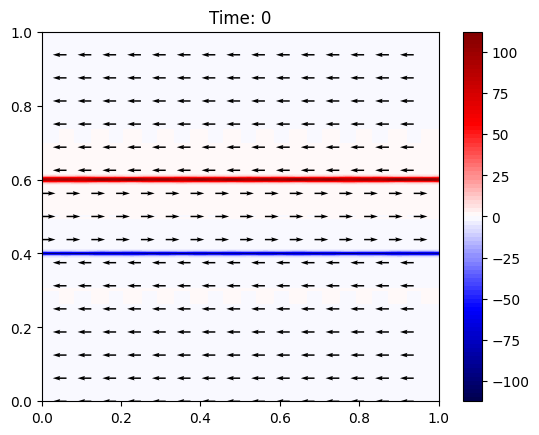

In [16]:
plot_init()

In [65]:
def simulation():
    # Genaral parameters
    n = 4                           # number of qubits
    N = 2**n                        # number of grid points
    dx = 1 / (N-1)                  # finite spacing
    dt = 0.1*2**-(n-1)              # finite time step
    T = 2                           # final time
    x = np.linspace(0, 1-dx, N)
    y = np.linspace(0, 1-dx, N)
    X, Y = np.meshgrid(x, y)
    u_0 = 1                         # initial velocity
    Re = 0.001*200*1e3
    L_box = 1                       # domain size

    # Define problem
    y_min = 0.4                     # lower interface 
    y_max = 0.6                     # upper interface
    h = 1/200                       # thickness of interface

    # Simulation parameters 
    n_steps = int(np.ceil(T/dt))    # time steps
    n_s = 2**(n-4)                  # Plot N/n_s number of arrows

    # Generate wave vectors
    kx_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    ky_1 = np.mod(1/2 + np.arange(N)/N, 1) - 1/2
    kx = kx_1 * 2*np.pi/dx
    ky = ky_1 * 2*np.pi/dx
    Kx, Ky = np.meshgrid(kx, ky)

    # Generate initial fields
    U, V = J(X, Y, u_0, y_min, y_max, h)
    dU, dV = D(X, Y, u_0, y_min, y_max, h, L_box)
    u = U + dU
    v = V + dV

    t = 0
    for step in range(n_steps):
        # Plot before step
        if step%10 == 0:
            plt.figure()
            plt.title(f"Time: {round(t, 5)}")
            plt.contourf(X, Y, Dx(v, dx)-Dy(u, dx), 100, cmap="seismic")
            plt.colorbar()
            plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
            # plt.quiver(X, Y, u, v, color="black")
            plt.xlim((0, 1))
            plt.ylim((0, 1))
            plt.show()

        u, v = solveNS(u, v, Kx, Ky, Re, dt, dx)
        t += dt
        np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/data_low_Re/u_{t}.npy", u)
        np.save(f"/Users/q556220/dev/TN_CFD/2D_TDJ/data_low_Re/v_{t}.npy", v)

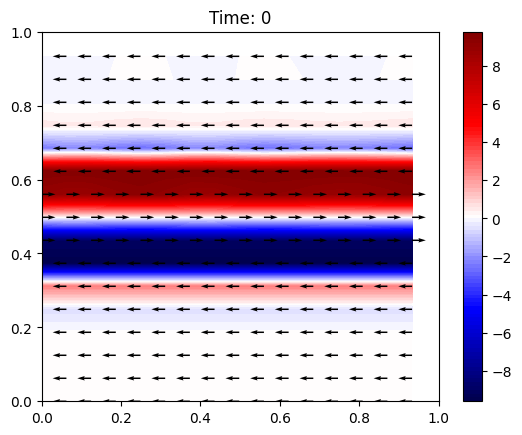

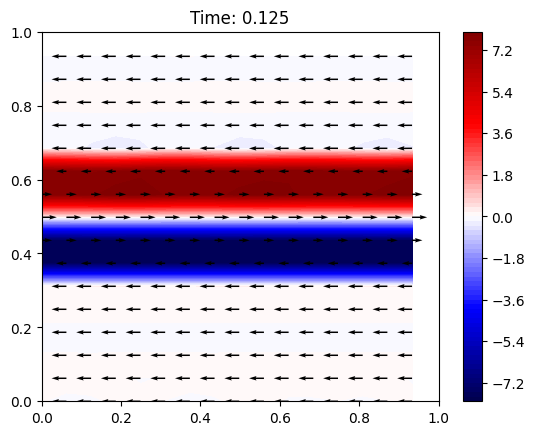

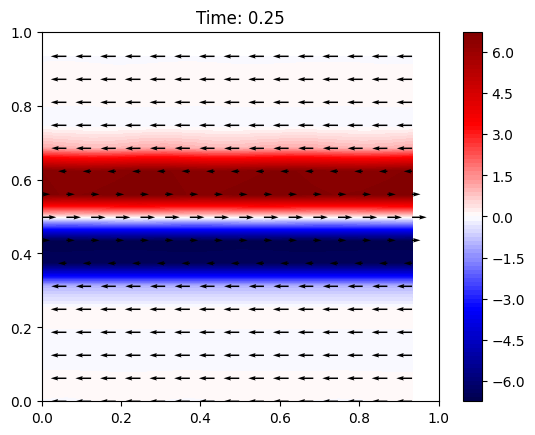

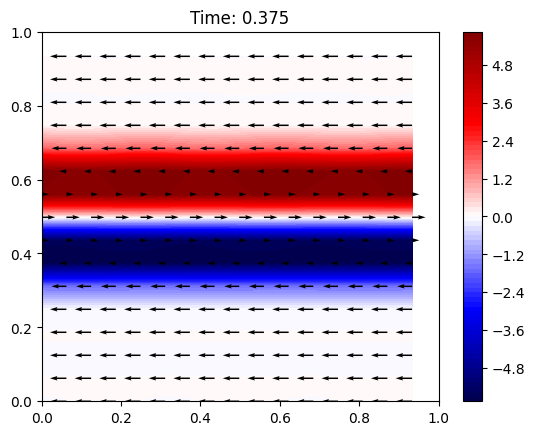

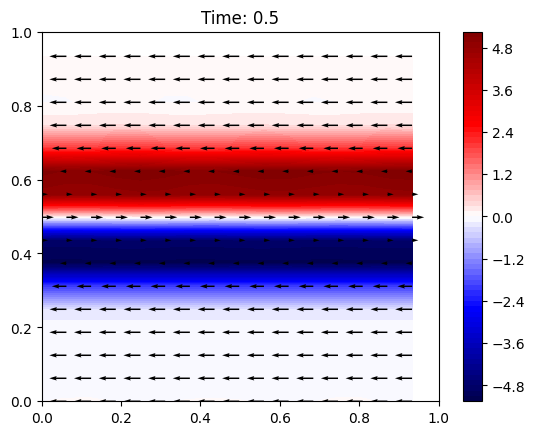

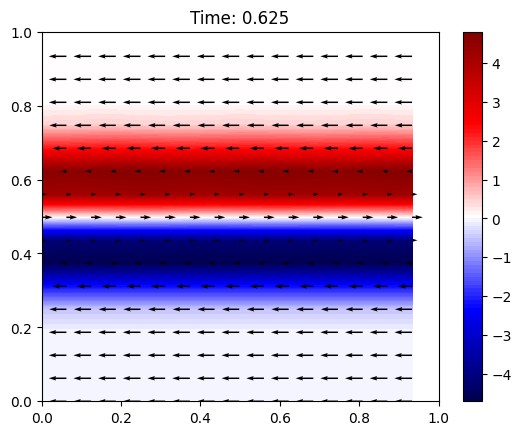

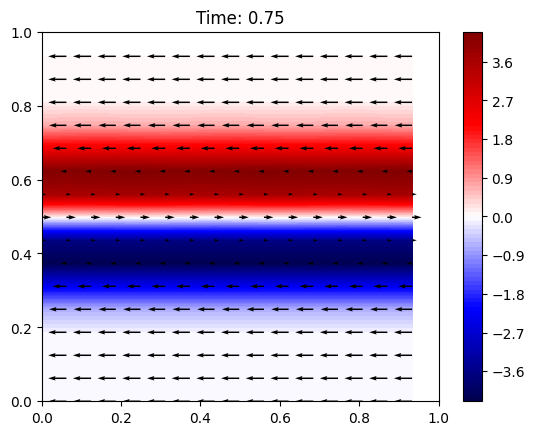

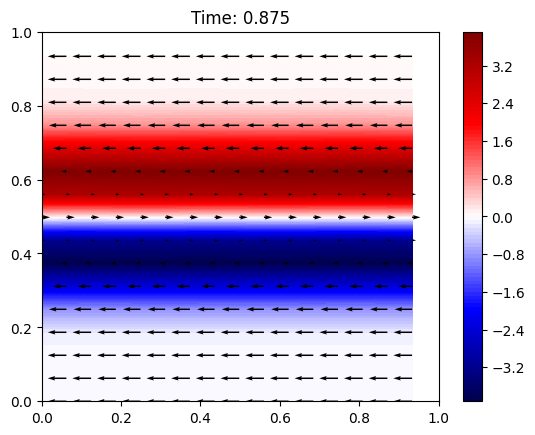

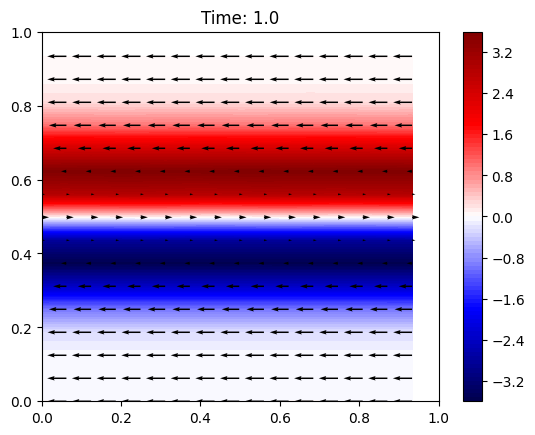

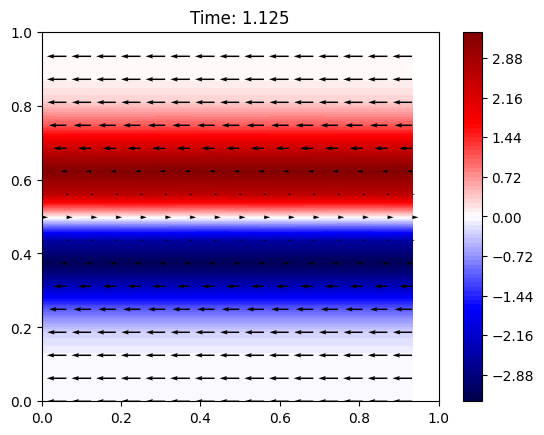

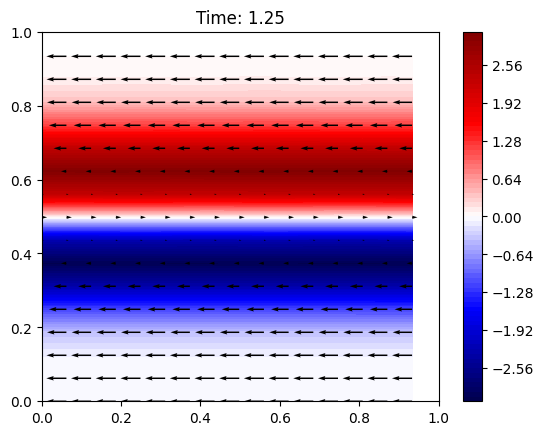

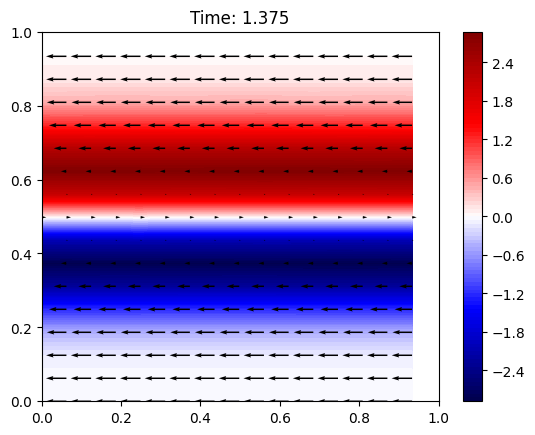

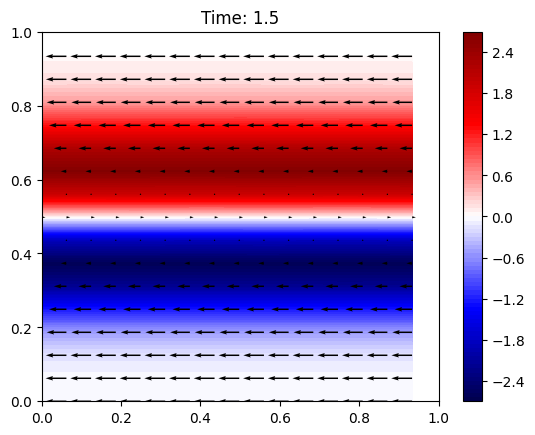

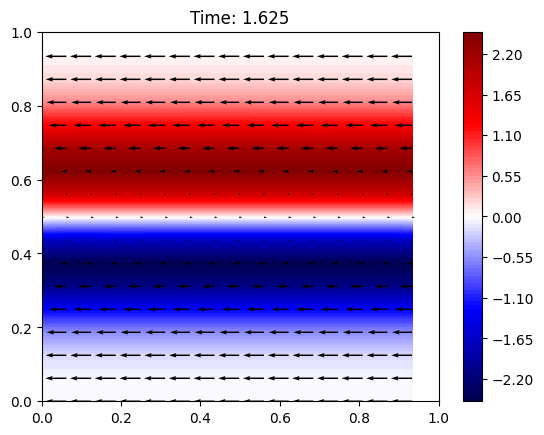

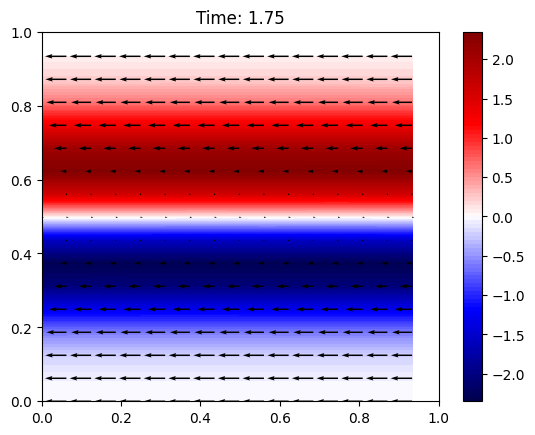

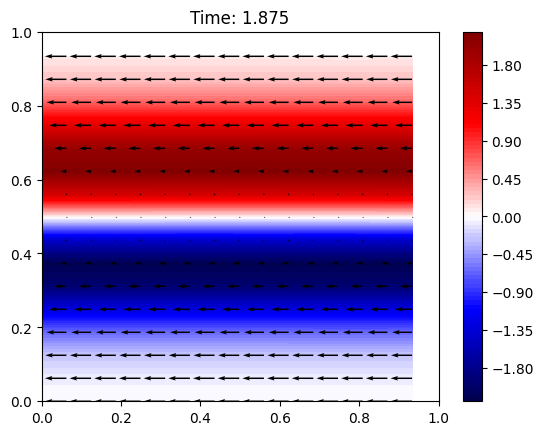

In [66]:
%matplotlib inline
simulation()